## face thing first

In [1]:
import os
os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/RA2_alpine_lads')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 
import os
import tensorflow as tf
import tensorflow_addons as tfa
from utils.config import Config
import dataset.train_dataset as dtd
import PIL
import PIL.ImageOps
from tensorflow.keras.utils import plot_model
test_config = Config()
from tensorflow.keras.models import load_model
from model import NASnet_multioutput
import itertools
import seaborn as sns

AUTOTUNE = tf.data.experimental.AUTOTUNE

from dataset import dataset_ops
import dataset.image_ops as ops

In [3]:
landmark_info = "/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/faces_landmarks/list_landmarks_celeba.txt"

In [7]:
landmark_data = pd.read_csv(landmark_info,sep="\s+|\t+|\s+\t+|\t+\s+",skiprows=1)

/mnt/jw01-aruk-home01/projects/ra_challenge/tensorflow2.0_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [8]:
landmark_data
# x = [0,2,4,6,8]
#y = [1,3,5,7,9]

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
000001.jpg,165,184,244,176,196,249,194,271,266,260
000002.jpg,140,204,220,204,168,254,146,289,226,289
000003.jpg,244,104,264,105,263,121,235,134,251,140
000004.jpg,796,539,984,539,930,687,762,756,915,756
000005.jpg,273,169,328,161,298,172,283,208,323,207
...,...,...,...,...,...,...,...,...,...,...
202595.jpg,1449,201,1530,201,1491,259,1457,282,1522,286
202596.jpg,172,186,222,186,193,220,171,230,222,230
202597.jpg,81,121,113,120,101,142,81,155,116,155
202598.jpg,223,73,255,72,241,94,225,108,254,105


In [6]:
dataset = tf.data.Dataset.from_tensor_slices((landmark_data.index.values, landmark_data.values))

In [7]:
def __load_image(file, y):
    file_path = "/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/faces_landmarks/img_align_celeba" + "/" + file 

    img = tf.io.read_file(file_path)    
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img, y

In [8]:
dataset = dataset.map(__load_image, num_parallel_calls=AUTOTUNE)

In [9]:
dataset_val = dataset.take(5000) 
dataset = dataset.skip(5000)
dataset = dataset.shuffle(buffer_size=200)  
dataset = dataset.batch(25)     
dataset = dataset_ops.randomly_augment_images(dataset,augments=[ops.random_brightness_and_contrast])
dataset = dataset.prefetch(buffer_size=AUTOTUNE) 

dataset_val = dataset_val.batch(25)

(25, 218, 178, 1)


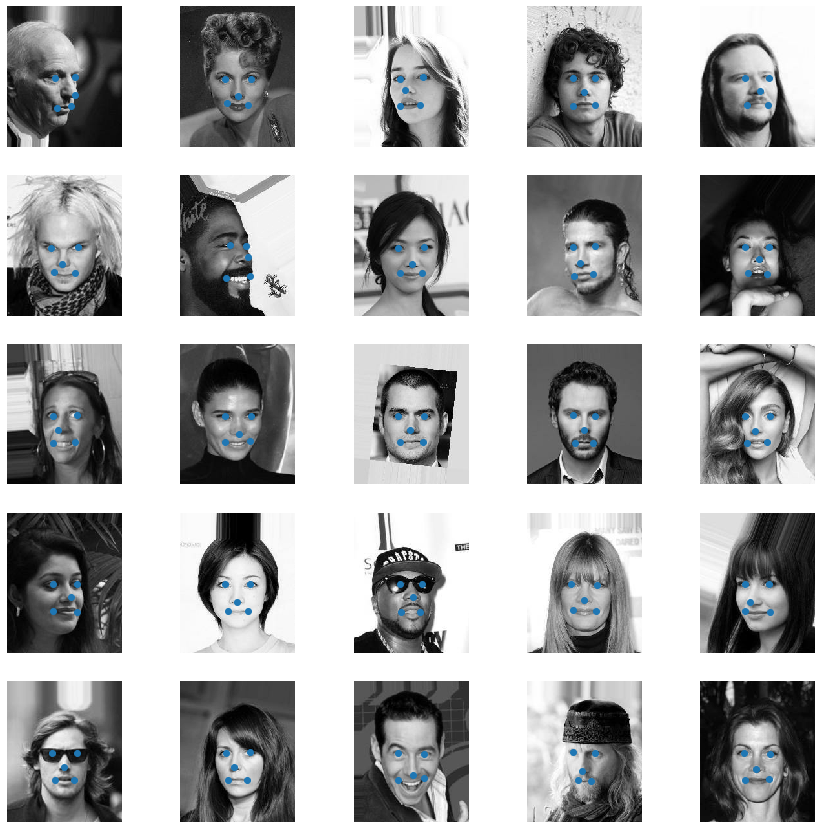

In [10]:
for a,b in dataset.take(1):
    print(a.shape)
    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.array(a[n])[:, :,0],cmap="gray")
        plt.scatter(np.array(b[n])[[0,2,4,6,8]],np.array(b[n])[[1,3,5,7,9]])
        plt.axis('off')


In [11]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 16, kernel_size=(3,3),activation="relu",input_shape=(218, 178, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters = 16, kernel_size=(3,3),activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(filters = 32, kernel_size=(3,3),activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters = 32, kernel_size=(3,3),activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(filters = 64, kernel_size=(3,3),activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters = 64, kernel_size=(3,3),activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(filters = 128, kernel_size=(3,3),activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters = 128, kernel_size=(3,3),activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='linear')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 216, 176, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 176, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 214, 174, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 214, 174, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 107, 87, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 105, 85, 32)       4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 105, 85, 32)       1

In [13]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

In [14]:
model.load_weights("weights/FACE_LANDMARK_simple_model_epoch_5")

In [18]:
H = model.fit(dataset, validation_data=dataset_val,
    epochs=5,validation_steps=10)

Epoch 1/5
7904/7904 [==============================] - 169s 21ms/step - loss: 430.5732 - mae: 5.8110 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/5
7904/7904 [==============================] - 157s 20ms/step - loss: 1.8307 - mae: 0.9228 - val_loss: 1.3130 - val_mae: 0.8146
Epoch 3/5
7904/7904 [==============================] - 161s 20ms/step - loss: 1.4311 - mae: 0.8331 - val_loss: 1.2512 - val_mae: 0.8026
Epoch 4/5
7904/7904 [==============================] - 165s 21ms/step - loss: 1.2657 - mae: 0.7921 - val_loss: 0.9649 - val_mae: 0.6807
Epoch 5/5
7904/7904 [==============================] - 166s 21ms/step - loss: 1.1559 - mae: 0.7657 - val_loss: 0.8576 - val_mae: 0.6360


In [ ]:
truths = [[],[],[]]
preds = [[],[],[]]  
for a,b in dataset_val.take(50):
    h = model.predict(a)
    for i in range(3):
        truths[i].extend(list(itertools.chain(*np.array(b[i]).tolist())))
        preds[i].extend(list(itertools.chain(*np.array(h[i]).tolist())))

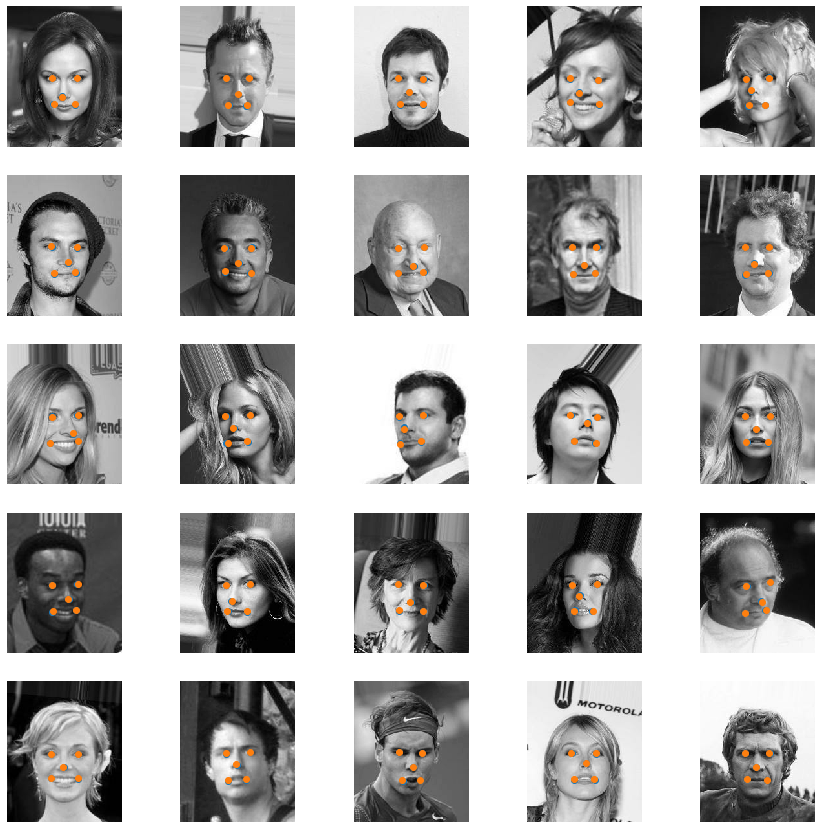

In [21]:
for a,b in dataset_val.skip(50).take(1):
    h = model.predict(a)
    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.array(a[n])[:, :,0],cmap="gray")
        plt.scatter(np.array(b[n])[[0,2,4,6,8]],np.array(b[n])[[1,3,5,7,9]])
        plt.scatter(np.array(h[n])[[0,2,4,6,8]],np.array(h[n])[[1,3,5,7,9]])
        plt.axis('off')

In [20]:
model.save_weights("weights/FACE_LANDMARK_simple_model_epoch_5")

# none of the crap down here works

In [55]:
from PIL import Image
import requests
from io import BytesIO

# url = "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTQhnHuvcWzyFD2TNCCC3kFKkf86T9IEObJ6QzAfn2Ahr93UtRw"

# response = requests.get(url)
# im = Image.open(BytesIO(response.content)).convert('L')
im = Image.open("/mnt/iusers01/jw01/mdefscs4/Capture.PNG").convert('L')
im = im.resize((178,218))

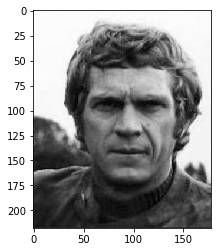

In [56]:
plt.imshow(np.array(im).reshape((218,178,1))[:, :,0],cmap="gray")

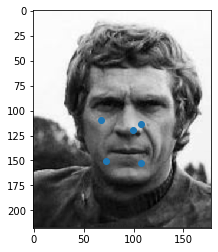

In [57]:
h = model.predict(np.array(im).reshape((1,218,178,1))/255.0)
plt.imshow(np.array(im).reshape((218,178,1))[:, :,0],cmap="gray")
plt.scatter(np.array(h[0])[[0,2,4,6,8]],np.array(h[0])[[1,3,5,7,9]])

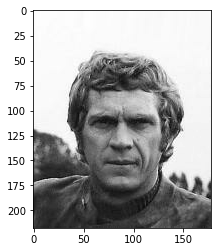

In [51]:
plt.imshow(np.array(a[n])[:, :,0],cmap="gray")

In [46]:
mobile_net = keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet', input_tensor=None, pooling=None)

In [47]:
new_model = keras.models.Sequential()
new_model.add(mobile_net)

In [48]:
new_model.add(keras.layers.MaxPooling2D((2,2)))
new_model.add(keras.layers.Flatten())
new_model.add(keras.layers.Dense(50, activation='relu'))
new_model.add(keras.layers.Dense(10, activation='linear'))

In [49]:
for layer in new_model.layers[:-2]:
    layer.trainable = False
new_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

In [50]:
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                576050    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                510       
Total params: 2,834,544
Trainable params: 576,560
Non-trainable params: 2,257,984
_________________________________________________________________


In [51]:
def resize_image(img,y):
    img = tf.image.resize_with_pad(img, 224, 224)
    img=tf.stack([img, img, img], axis=-1)
    img=tf.reshape(img, shape=(25,224,224,3))
    return img,y
dataset = dataset.map(resize_image)
dataset_val = dataset_val.map(resize_image)

In [54]:
H = new_model.fit(dataset, validation_data=dataset_val,
    epochs=30,validation_steps=10)

Epoch 1/30
   1983/Unknown - 49s 25ms/step - loss: 65.5014 - mae: 6.2884

KeyboardInterrupt: 

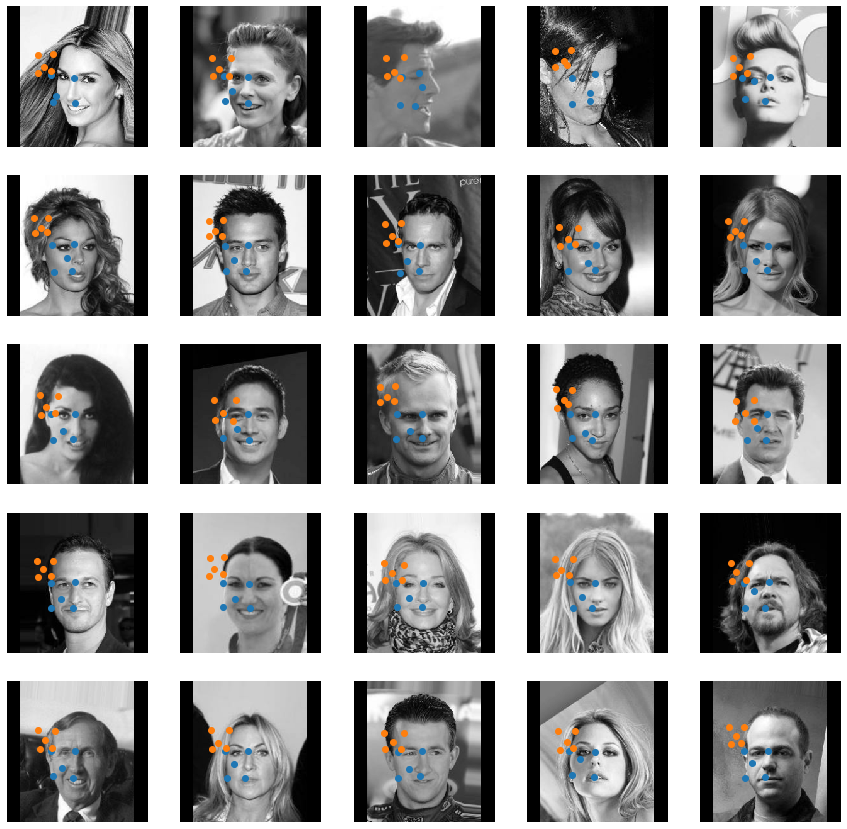

In [55]:
for a,b in dataset_val.take(1):
    h = new_model.predict(a)
    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.array(a[n])[:, :,0],cmap="gray")
        plt.scatter(np.array(b[n])[[0,2,4,6,8]],np.array(b[n])[[1,3,5,7,9]])
        plt.scatter(np.array(h[n])[[0,2,4,6,8]],np.array(h[n])[[1,3,5,7,9]])
        plt.axis('off')